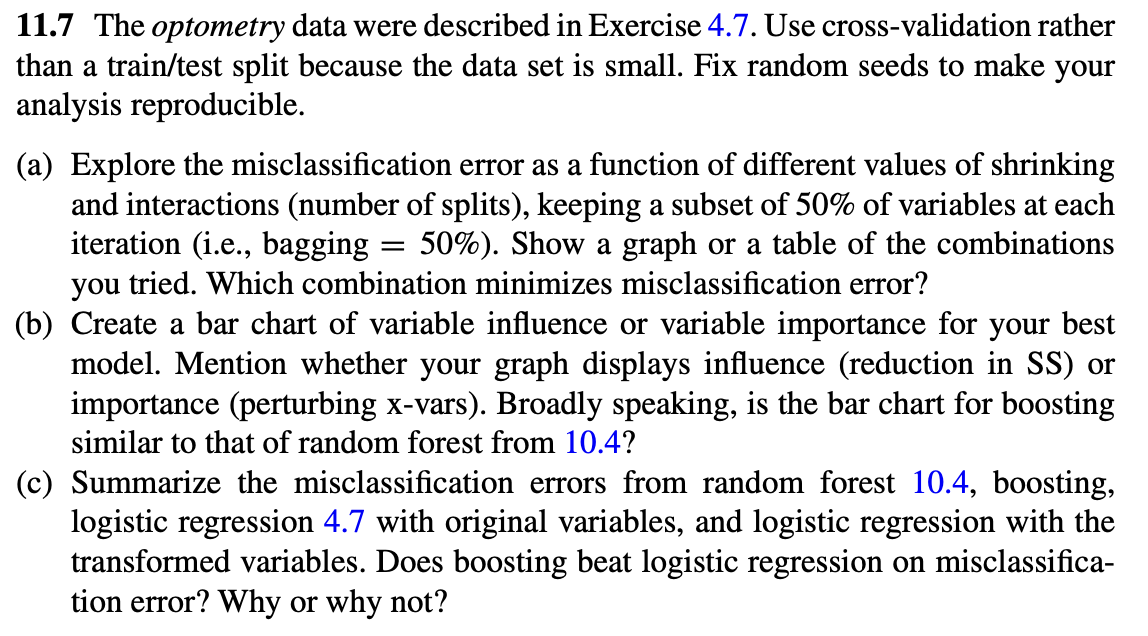

First, I load in the required packages and read the dataset.

In [ ]:
# loading in packages
library(tidyverse)
library(gbm)
library(xgboost)
library(randomForest)
# read the csv
optom_data = read.csv("optometry.csv")

**Part a)** 

Here, I set up some of the parameters required for the xgboost model. I defined a wide range of learning rates and depth values, in order to effectively determine a combination that can lower the misclassification error. In addition, 10-fold cross validation was used, as opposed to training and testing data (as stated in the question). Choice here was arbitrary - coin flip between 5 and 10. 

In [88]:
# set up the cross-validation parameters
nfolds = 10
nrounds = 100
early_stop_rounds = 10
params = list(
  objective = "binary:logistic",
  eval_metric = "error"
)
# set up the learning rates and the depths
lrs = seq(from = 0, to = 1, by = 0.01)
depths = seq(from = 1, to = 10, by = 1)

The learning rate values were from 0 to 1, increasing by 0.01. [0, 0.01, 0.02, ... , 0.98, 0.99, 1]. 

The depth values were from 1 to 10, increasing by 1. [1, 2, 3, ..., 9, 10]

To use the xgboost function in R, it is necessary to convert the input dataframe into a specific matrix. So, that's what happens here, in addition to setting up the results table. 

In [85]:
# change the data to a DMatrix
data_matrix = xgb.DMatrix(data = as.matrix(optom_data[-1]), label = optom_data[[1]])
# set up the results
results = expand.grid(learning_rate = lrs, max_depth = depths, error = NA)

Now, here comes the bagging. I made an assumption here. 
- I assumed that bagging was meant to be applied to both the rows and the columns at a 50% rate. I wasn't sure if this was implied in the question. 
    

In [91]:
# setting the seed
set.seed(278182)
for (lr in lrs) {
  for (depth in depths) {
    # update the parameters
    params$eta = lr
    params$max_depth = depth
    params$subsample = 0.5 # 50% of the rows
    params$colsample_bytree = 0.5 # 50% of the columns
    # perform cross-validation
    cv_results = xgb.cv(
      params = params,
      data = data_matrix,
      nfold = nfolds,
      nrounds = nrounds,
      early_stopping_rounds = early_stop_rounds,
      verbose = 0, 
      prediction = FALSE,
      maximize = FALSE
    )
    # store the best error for the current parameter combination
    best_error = min(cv_results$evaluation_log$test_error_mean)
    results[results$learning_rate == lr & results$max_depth == depth, "error"] = best_error
  }
}

    learning_rate max_depth     error
420          0.15         5 0.1623273


[1] 0.1623273

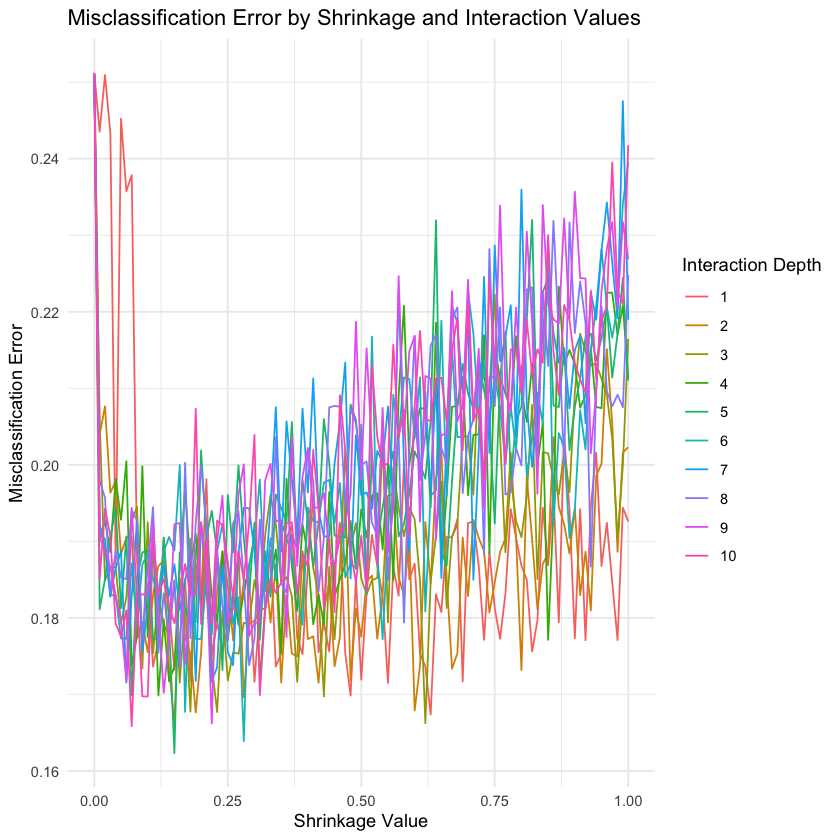

In [203]:
# best combo is the one that minimizes error
best_combination = results[which.min(results$error),]

# print out the best one
print(best_combination)

# plot the results
library(ggplot2)
ggplot(results, aes(x = learning_rate, y = error, color = as.factor(max_depth))) +
  geom_line() +
  labs(title = "Misclassification Error by Shrinkage and Interaction Values",
       x = "Shrinkage Value",
       y = "Misclassification Error",
       color = "Interaction Depth") +
  theme_minimal()

misclass_error_boost = results$error[which.min(results$error)]

I will say - I'm not exactly sure how I was meant to plot the values I tried. So, I figured stating the values I tried above, and printing the best combination was the best idea. Graph is... merely supplementary, if you can even call it that. 

To finalize, our best combination is at a learning rate of 0.15, a max depth of 5, and a misclassification error rate of 0.1623273.

**Part b)**

Evaluating the model again with the best parameters in order to determine the variable importance...

In [153]:
# get the best combo
best_lr = best_combination$learning_rate
best_depth = best_combination$max_depth

# Set up the parameters for the best model
best_params <- list(
  booster = "gbtree",
  eta = best_lr,
  max_depth = best_depth,
  subsample = 0.5,
  colsample_bytree = 0.5,
  objective = "binary:logistic",
  eval_metric = "error"
)
set.seed(342132)
# Train the best model on the full dataset
best_model = xgb.train(
  params = best_params,
  data = data_matrix,
  nrounds = nrounds # The number of rounds determined to be optimal during CV
)

I now calculate the **importance**.

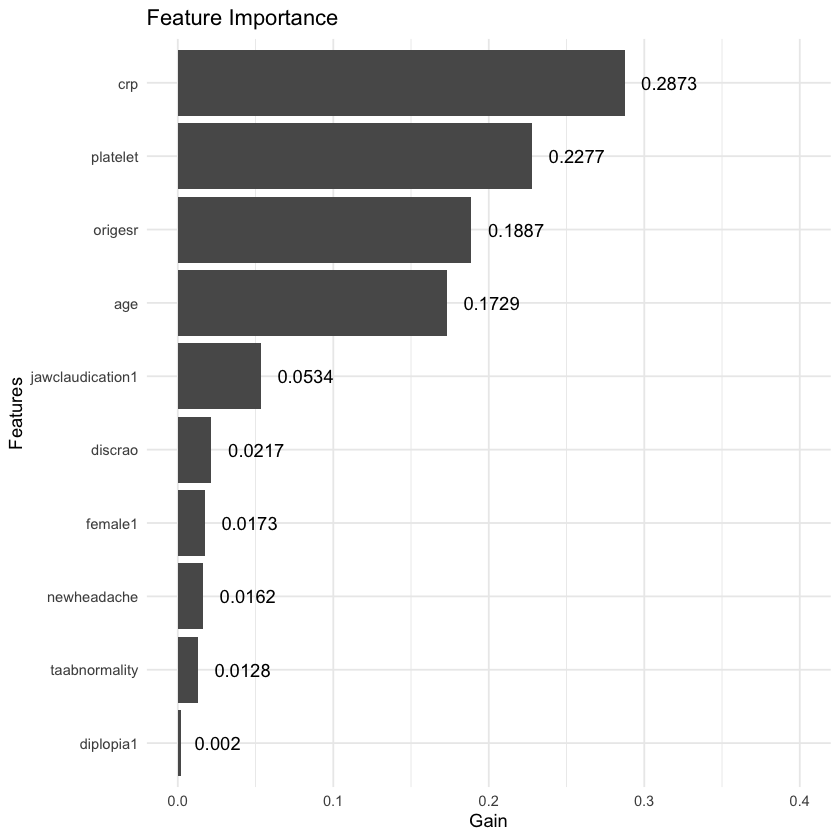

In [156]:
# variable importance calculations
importance_matrix = xgb.importance(feature_names = colnames(optom_data[-1]), model = best_model)
# convert to a dataframe for the bar plot
importance_data = as.data.frame(importance_matrix)

Now, we will fit the random forest model in 10.4, and then compare the importance. 

**Sub Part a)... ?**

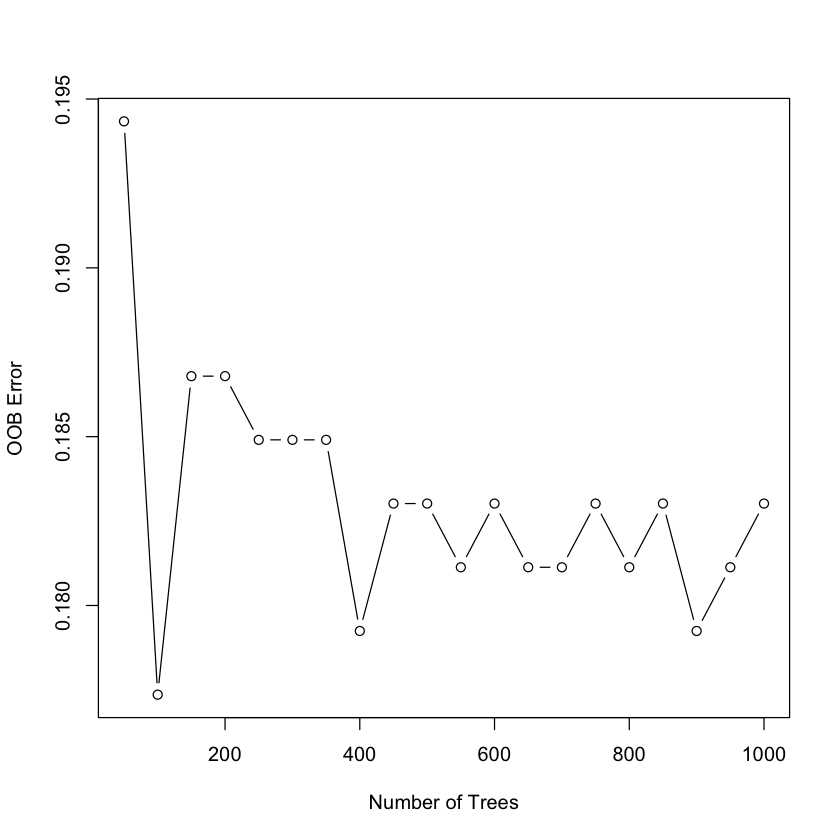

In [221]:
# take the square root of the # of variables
# we have 10 variables, take the floor of the square root
numvs = floor(sqrt(ncol(optom_data) - 1))
# set a sequence of tree # values to try
numtrees = seq(50, 1000, by = 50)
# set a vector to store OOB error
oobs = numeric(length(numtrees))
# set the labels and the predictors
labs = as.factor(optom_data[, 1])
preds = optom_data[, -1]
# loop through tree sizes
for (i in seq_along(numtrees)) {
  set.seed(3294082)
  rf_model = randomForest(preds, labs, mtry = numvs, ntree = numtrees[i], importance = TRUE)
  oobs[i] = rf_model$err.rate[numtrees[i], "OOB"]
}
plot(numtrees, oobs, type = "b", xlab = "Number of Trees", ylab = "OOB Error")

**Sub Part b)...?**

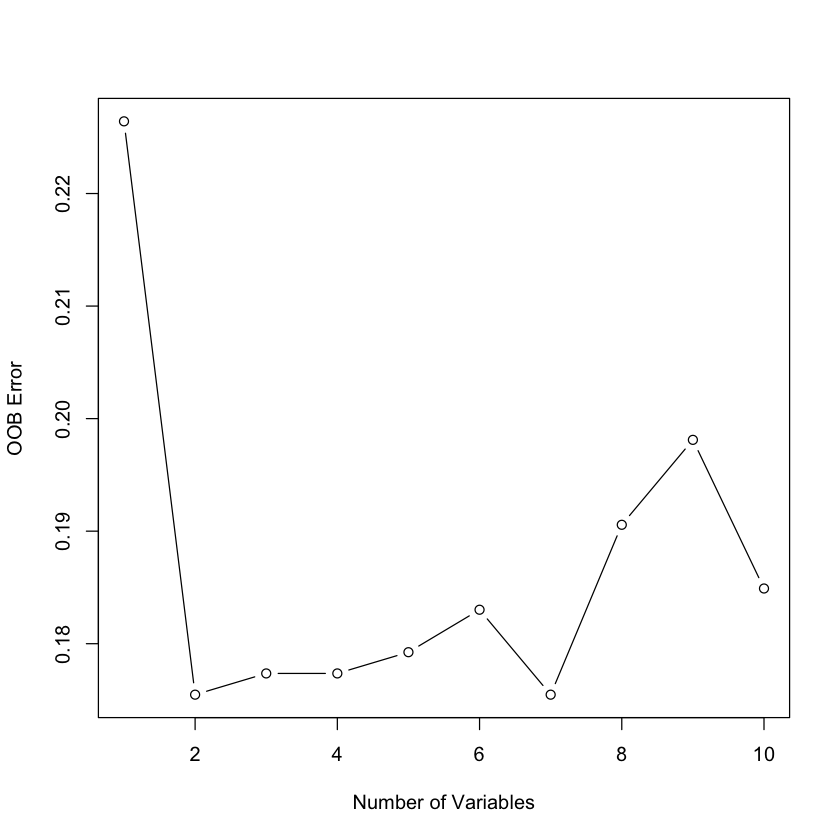

In [222]:
# pick tree with lowest oob error
fixed_ntree = numtrees[which.min(oobs)]
# define a range of mtry values
mtry_seq = 1:ncol(preds)
# to store oobs
oobs_mtry = numeric(length(mtry_seq))
# loop over mtry values
for (i in mtry_seq) {
  set.seed(3294082)
  rf_model_mtry = randomForest(preds, labs, mtry = i, ntree = fixed_ntree, importance = TRUE)
  oobs_mtry[i] = rf_model_mtry$err.rate[fixed_ntree, "OOB"]
}
plot(mtry_seq, oobs_mtry, type = "b", xlab = "Number of Variables", ylab = "OOB Error")


**Sub Part c)...?**

The below importance was calculated based on the "MeanDecreaseGini" criteria from the randomForest importance feature. 

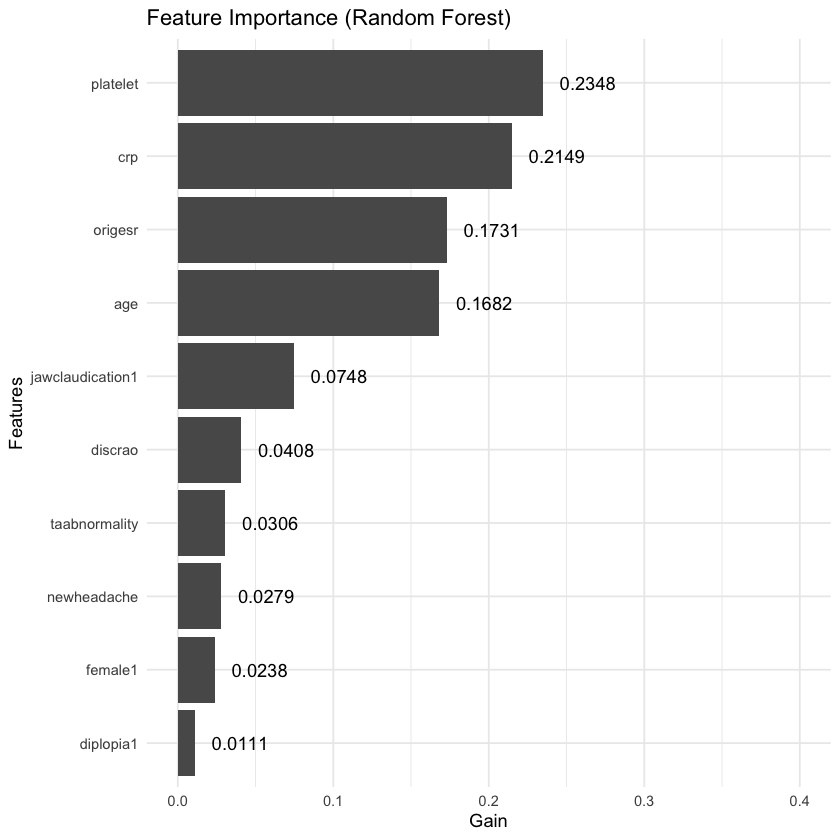

In [189]:
# gets the best # of variables
best_mtry = mtry_seq[which.min(oobs_mtry)]
set.seed(342323)
# fit the best model
final_rf_model = randomForest(preds, labs, mtry = best_mtry, ntree = fixed_ntree, importance = TRUE)
var_importance = final_rf_model$importance
percent_importance = var_importance[, "MeanDecreaseGini"]/sum(var_importance[, "MeanDecreaseGini"])
var_importance = data.frame(
  Feature = rownames(var_importance),
  ImportancePercentage = percent_importance
)
ggplot(var_importance, aes(x = reorder(Feature, ImportancePercentage), y = ImportancePercentage)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(ImportancePercentage, 4)), hjust = -0.3) + 
  labs(x = "Features", y = "Gain", title = "Feature Importance (Random Forest)", color = "white") +
  scale_y_continuous(limits = c(0, 0.4)) +
  coord_flip() + 
  theme_minimal() 

And, bringing back the xgboost plot:

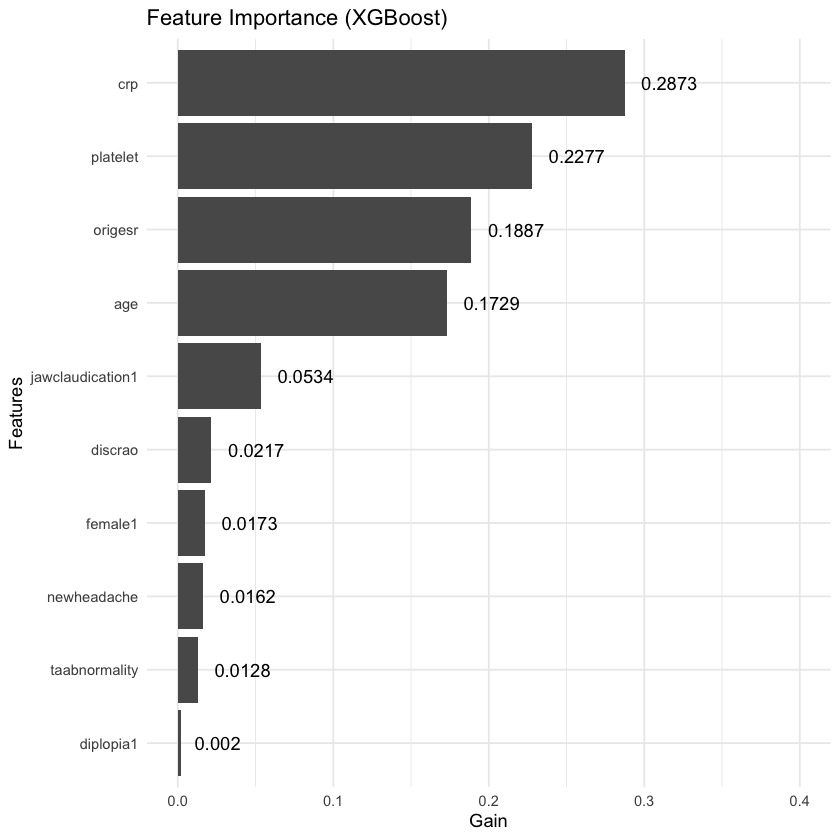

In [184]:
ggplot(importance_data, aes(x = reorder(Feature, Gain), y = Gain)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(Gain, 4)), hjust = -0.3) + 
  labs(x = "Features", y = "Gain", title = "Feature Importance (XGBoost)", color = "white") +
  scale_y_continuous(limits = c(0, 0.4)) +
  coord_flip() + 
  theme_minimal() 

We see overall agreement between the two models, specifically in the top and bottom 5 - with some slight rearrangement. So, broadly speaking, we do see overall agreement between the two models. However, the rearrangement of the variates is certainly of note. 

**Part c)**

... who's ready for sub-sub Part a)? 

In [195]:
# fitting the logistic regression to all of the variates
logistic_fit = glm(formula = tabxneg0 ~., family = "binomial", data = optom_data)
# fitting the logistic regression for crp and origesr on a log scale
form = tabxneg0 ~ age + female1 + newheadache + 
    taabnormality + jawclaudication1 + platelet + discrao +
    diplopia1 + log(origesr) + log(crp)
logistic_log_fit = glm(formula = form, family = "binomial", data = optom_data)

Using a cutoff of 0.5 for the logistic models, we get the misclassification error.

In [204]:
# for the regular logistic model
logistic_fit_probs = predict(logistic_fit, type = "response")
logistic_fit_pred = ifelse(logistic_fit_probs > 0.5, 1, 0)
misclass_error_logit = mean(logistic_fit_pred != optom_data$tabxneg0)
# for the logistic log model
logistic_log_fit_probs = predict(logistic_log_fit, type = "response")
logistic_log_fit_pred = ifelse(logistic_log_fit_probs > 0.5, 1, 0)
misclass_error_logit_log = mean(logistic_log_fit_pred != optom_data$tabxneg0)

Now, going back to the misclassification error for the random forest:

In [218]:
pred_labels = predict(final_rf_model, newdata = preds)
misclass_error_rf = mean(pred_labels != labs)

In [219]:
errs = data.frame(
  Model = c("XGBoost", "Random Forest", "Logistic", "LogLogistic"),
  MisClassError = c(misclass_error_boost, misclass_error_rf, misclass_error_logit, misclass_error_logit_log)
)

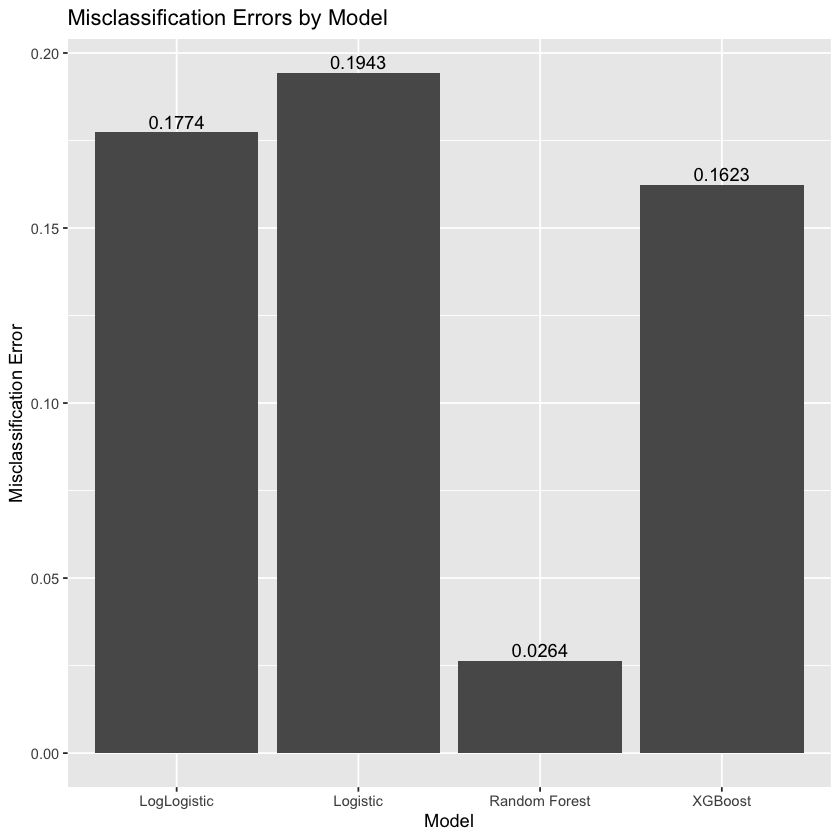

In [220]:
ggplot(errs, aes(x = Model, y = MisClassError)) + geom_bar(stat = "identity") +
  geom_text(aes(label = round(MisClassError, 4)), vjust = -0.3) + 
  labs(x = "Model", y = "Misclassification Error", title = "Misclassification Errors by Model", color = "white")

Now, here I'm assuming I'm not to compare the random forest misclassification error (since it's always pretty close to 0 for training data, and it isn't explicitly stated to do so in the question), but we can see that the XGBoost algorithm performs noticeably better than both the transformed logistic (i.e. taking the logarithms of the two variates origesr and crp), and the regular logistic regression. 

Now, to consider why the boosting performs better than logistic regression, we can simply consider the complexity and design of boosting. The boosting algorithm "learns" from previous errors made in prediction through the gradient evaluation process, and thus isn't a "one size fits all" model based on a single estimation run. The model can learn from previous mistakes, and improve based on them. The model is also much more flexible than logistic regression, since it doesn't assume any linearity of the coefficients in the model. So, it shouldn't come as a shock that XGBoost performs better. 